In [95]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression

In [60]:
modeling_df = pd.read_csv('data/cleaned_data.csv')

In [61]:
# Define target & feature variables
X = modeling_df.drop(columns=['isFraud'])  
y = modeling_df['isFraud']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)


Random Forest

In [62]:
#Training the initial model
rfc_model = RandomForestClassifier(random_state=22)

# Fit the model
rfc_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rfc_model.predict(X_test)

In [69]:
# Define hyperparameters to search over with random distributions
param_dist = {
    'n_estimators': randint(100, 500),  # Number of trees
    'max_depth': [None, 10, 20],  # Depth of the trees
    'min_samples_split': randint(2, 10),  # Min number of samples required to split a node
    'min_samples_leaf': randint(1, 10)    # Min number of samples required at a leaf node
}

# Initialize RandomizedSearchCV with cross-validation
random_search = RandomizedSearchCV(estimator=rfc_model, param_distributions=param_dist, 
                                     n_iter=50, cv=5, scoring='f1', n_jobs=-1, random_state=22)

# Fit model to the training data
random_search.fit(X_train, y_train)

# Get best hyperparameters
best_params_random = random_search.best_params_
print(f"Best hyperparameters from RandomSearch: {best_params_random}")

# Retrain model with best hyperparameters
best_rfc_model_random = random_search.best_estimator_

# Get predicted probabilities for class 1 (fraud)
y_pred_proba = best_rfc_model_random.predict_proba(X_test)[:, 1]  # Probabilities for class 1

# Set new threshold
threshold = 0.3 

# Adjust predictions based on new threshold
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

#Generate report
print(f"Adjusted F1 Score: {f1_score(y_test, y_pred_adjusted)}")
print(f"Adjusted Accuracy Score: {accuracy_score(y_test, y_pred_adjusted)}")
print(classification_report(y_test, y_pred_adjusted))


Best hyperparameters from RandomSearch: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 421}
Adjusted F1 Score: 0.6956521739130435
Adjusted Accuracy Score: 0.9994499449944995
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12711
           1       1.00      0.53      0.70        15

    accuracy                           1.00     12726
   macro avg       1.00      0.77      0.85     12726
weighted avg       1.00      1.00      1.00     12726



          Feature  Importance
1   oldbalanceOrg    0.392760
0          amount    0.222903
5     BalanceDiff    0.141542
4  newbalanceDest    0.122409
2  newbalanceOrig    0.069168
3  oldbalanceDest    0.051217


<function matplotlib.pyplot.show(close=None, block=None)>

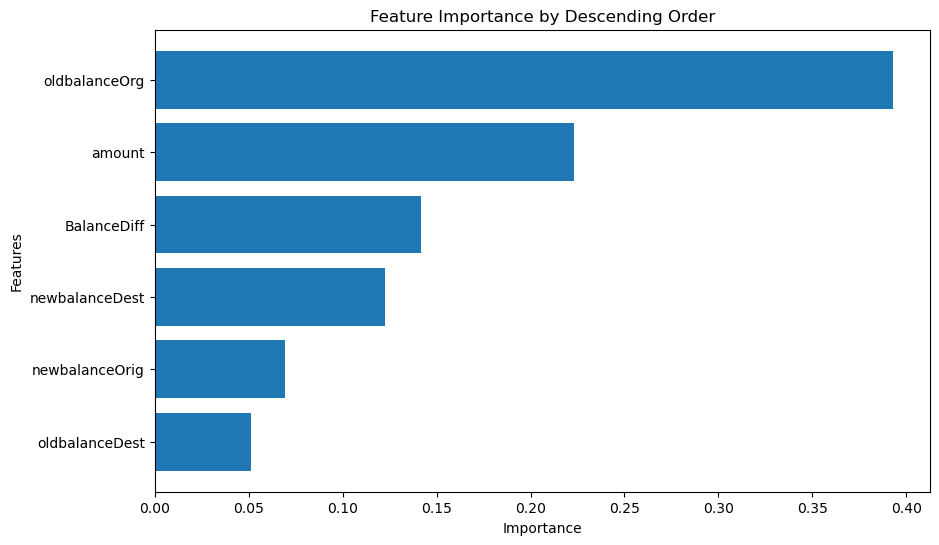

In [100]:
# Get Feature Importances
feature_importances = best_rfc_model_random.feature_importances_

# Create a df to hold feature names and importance values
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort df by descending order of importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance by Descending Order')
plt.gca().invert_yaxis()
plt.show


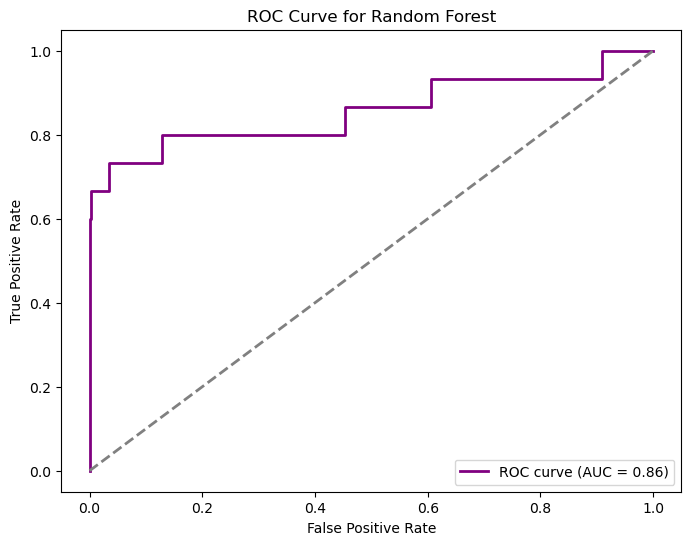

In [89]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='purple', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest')
plt.legend(loc='lower right')
plt.show()

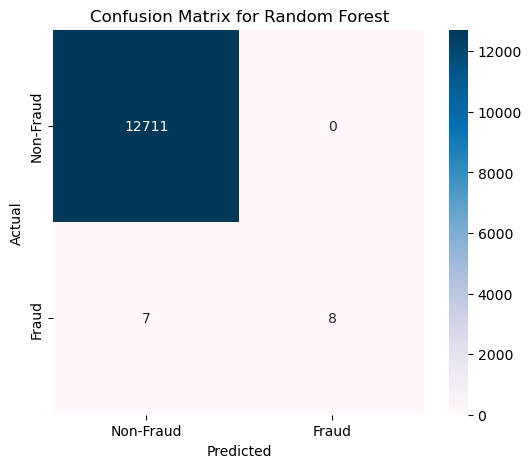

In [90]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_adjusted)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='PuBu', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest')
plt.show()

Logistic Regression

In [77]:
# Create and fit logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Train logistic regression model
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

# Predict using the test set
y_pred = logistic_model.predict(X_test)
y_pred_proba = logistic_model.predict_proba(X_test)[:, 1]  # Get probability for the positive class

# Generate report
print(f"F1 Score: {f1_score(y_test, y_pred)}")
print(f"Accuracy Score: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

F1 Score: 0.6363636363636364
Accuracy Score: 0.9993713657079993
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     12711
           1       1.00      0.47      0.64        15

    accuracy                           1.00     12726
   macro avg       1.00      0.73      0.82     12726
weighted avg       1.00      1.00      1.00     12726



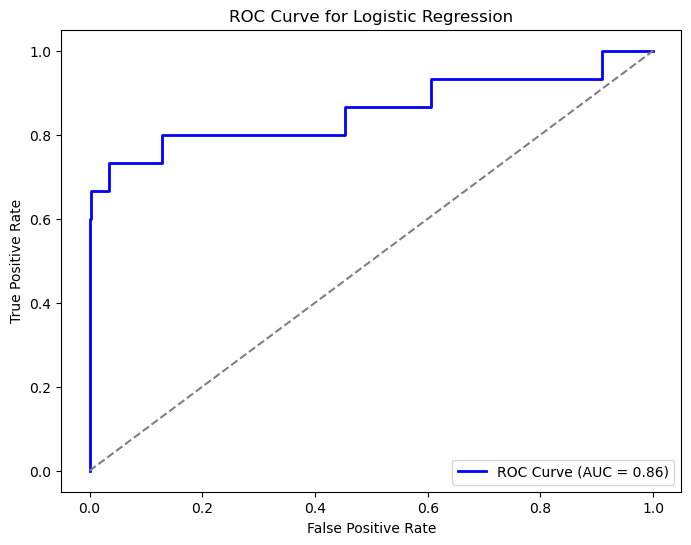

In [98]:
# Get predicted probabilities for the positive class (fraud)
y_pred_proba = logistic_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc='lower right')
plt.show()

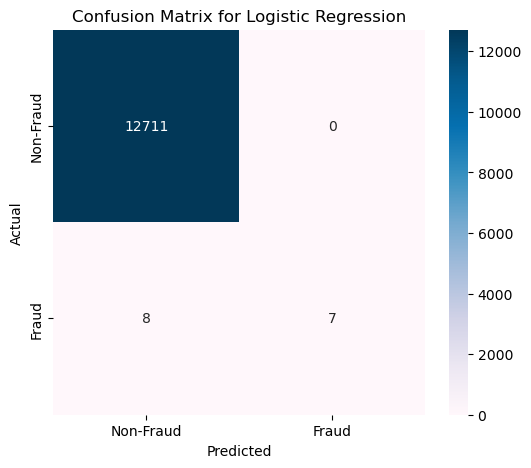

In [85]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='PuBu', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()